In [1]:
import pickle
import networkx as nx
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np



%matplotlib inline

# Setup

In [2]:
movies = pickle.load(open('../data/movies.p', 'rb'))

In [3]:
movie_0 = movies[movies['movie_id'] == 'm0']

In [4]:
# count character interactions and add to df

counts = movie_0.groupby(['char_id_from', 'char_id_to']).size().reset_index(name = 'count')

movie_0 = movie_0.merge(counts, on = ['char_id_from', 'char_id_to'])

In [5]:
movie_0.head(3)

,gender_to,movie_id,gender_from,char_id_from,char_id_to,line_id,words,movie_year,genre,count
0,m,m0,f,u0,u2,L194,we make quick roxanne korrine andrew barrett i...,1999,comedy,69
1,m,m0,f,u0,u2,L195,well i think we start pronunciation okay you,1999,comedy,69
2,m,m0,f,u0,u2,L196,hacking gagging spit part please,1999,comedy,69


# Network analysis

### Create graph

In [6]:
g = nx.from_pandas_edgelist(movie_0, source = 'char_id_from', target = 'char_id_to', edge_attr = ['count'])

In [7]:
g.edges(data = True)

EdgeDataView([('u0', 'u2', {'count': 69}), ('u0', 'u3', {'count': 18}), ('u0', 'u4', {'count': 14}), ('u0', 'u5', {'count': 60}), ('u0', 'u11', {'count': 31}), ('u2', 'u7', {'count': 69}), ('u2', 'u9', {'count': 24}), ('u4', 'u5', {'count': 10}), ('u4', 'u7', {'count': 15}), ('u4', 'u9', {'count': 32}), ('u5', 'u6', {'count': 42}), ('u5', 'u8', {'count': 9}), ('u5', 'u9', {'count': 171}), ('u5', 'u11', {'count': 30}), ('u6', 'u7', {'count': 10}), ('u7', 'u9', {'count': 26}), ('u8', 'u9', {'count': 13}), ('u1', 'u9', {'count': 6}), ('u11', 'u10', {'count': 20})])

### Create {character: gender} dictionary

In [8]:
gender_from = pd.Series(movie_0['gender_from'].values, index = movie_0['char_id_from']).to_dict()
gender_to = pd.Series(movie_0['gender_to'].values, index = movie_0['char_id_to']).to_dict()
gender_dict = {**gender_from, **gender_to} #combines the two dictionaries

### Set gender attribute for the character nodes

In [9]:
nx.set_node_attributes(g, name = 'gender', values = gender_dict)

In [10]:
g.nodes(data = True)

NodeDataView({'u0': {'gender': 'f'}, 'u2': {'gender': 'm'}, 'u3': {'gender': 'f'}, 'u4': {'gender': 'm'}, 'u5': {'gender': 'f'}, 'u6': {'gender': 'f'}, 'u7': {'gender': 'm'}, 'u8': {'gender': '?'}, 'u1': {'gender': 'm'}, 'u9': {'gender': 'm'}, 'u11': {'gender': 'm'}, 'u10': {'gender': 'f'}})

### Exploration

In [11]:
g.degree('u0') #number of connections

5

In [12]:
g.degree('u0', weight = 'count') #number of interactions that u0 has

192

In [13]:
list(g.neighbors('u0')) #connections

['u2', 'u3', 'u4', 'u5', 'u11']

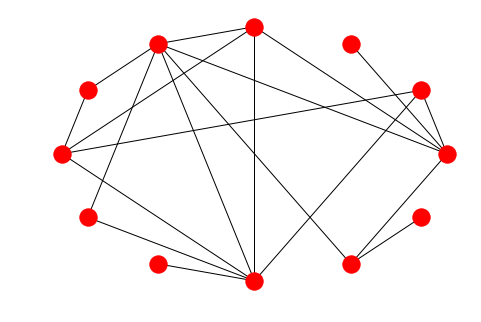

In [14]:
nx.draw_circular(g) #circle shaped graph

In [15]:
nx.degree_histogram(g) #the degree values are the index in the list

[0, 3, 2, 2, 2, 1, 2]

# Measuring centrality
* Degree centrality: fraction of nodes that each node is connected to
* Closeness centrality: average length of the shortest path from one node to each other node
* Betweenness centrality: quantifies how often a node acts as a bridge along the shortest path between two other nodes
* Eigenvector centrality: a measure of the influence of a node in the network
    * Connections to high-scoring nodes contribute more to the score than connections to low-scoring nodes
    * PageRank is a variant of eigenvector centrality

*Sources:* networkx documentation and https://en.wikipedia.org/wiki/Centrality

In [16]:
gender = pd.DataFrame(list(gender_dict.items()), columns = ['char_id', 'gender'])
degree = pd.DataFrame(list(nx.degree_centrality(g).items()), columns=['char_id','degree'])
closeness = pd.DataFrame(list(nx.closeness_centrality(g).items()), columns=['char_id','closeness'])
betweenness = pd.DataFrame(list(nx.betweenness_centrality(g).items()), columns=['char_id','betweenness'])
eigenvector = pd.DataFrame(list(nx.eigenvector_centrality(g).items()), columns=['char_id','eigenvector'])

In [17]:
dfs = [gender, degree, closeness, betweenness, eigenvector]

network = reduce(lambda left, right: pd.merge(left, right, on='char_id'), dfs)

In [18]:
network

,char_id,gender,degree,closeness,betweenness,eigenvector
0,u0,f,0.454545,0.611111,0.266061,0.351143
1,u4,m,0.363636,0.578947,0.063030,0.388006
2,u5,f,0.545455,0.687500,0.336970,0.448150
3,u2,m,0.272727,0.550000,0.049697,0.276552
4,u6,f,0.181818,0.478261,0.013333,0.191545
5,u1,m,0.090909,0.392857,0.000000,0.109133
6,u7,m,0.363636,0.500000,0.051515,0.322043
7,u8,?,0.181818,0.500000,0.000000,0.220586
8,u10,f,0.090909,0.354839,0.000000,0.052697
9,u3,f,0.090909,0.392857,0.000000,0.087329


### Analysis by gender

In [19]:
operations = {'degree': np.mean, 'closeness': np.mean, 'betweenness': np.mean, 'eigenvector': np.mean}

grouped = network.groupby('gender').agg(operations).reset_index()

In [20]:
grouped = grouped[grouped['gender'] != '?']
grouped

,gender,degree,closeness,betweenness,eigenvector
1,f,0.272727,0.504914,0.123273,0.226173
2,m,0.318182,0.526121,0.100303,0.291073


# Drawing the graph

### Setup

In [21]:
plt.figure(figsize = (12, 12))

layout = nx.spring_layout(g, iterations = 50)
#layout = nx.circular_layout(g)

### Node sizes based on number of connections

In [22]:
female = [char for char, gender in gender_dict.items() if gender == 'f']
male = [char for char, gender in gender_dict.items() if gender == 'm']
unknown = [char for char, gender in gender_dict.items() if gender == '?']

female_sizes = [g.degree(char) * 50 for char in female]
male_sizes = [g.degree(char) * 50 for char in male]
unknown_sizes = [g.degree(char) * 50 for char in unknown]

### Edge widths based on number of interactions between two nodes

In [23]:
lst = list(g.edges(data = True))
counts = np.array([d['count'] for c1, c2, d in lst])

counts


array([ 69,  18,  14,  60,  31,  69,  24,  10,  15,  32,  42,   9, 171,
        30,  10,  26,  13,   6,  20])

In [24]:
#normalize the counts
minimum = np.min(counts)
maximum = np.max(counts)

counts = (counts - minimum) / (maximum - minimum) + 0.05 #add a little bit so none are zero

counts = counts * 5

### Draw

#### Get character names to use as labels

In [66]:
headers = ['character_id', 'name', 'movie_id', 'movie_title', 'gender', 'position']

filepath = '../cornell_movie_dialogs_corpus/movie_characters_metadata.txt'

lines = []

with open(filepath, 'r', encoding = 'iso-8859-1') as f:
    for line in f:
        cols = line.split(' +++$+++ ')
        lines.append(cols)
            
characters = pd.DataFrame(lines, columns = headers)
    
characters = characters[['character_id', 'movie_id', 'name', 'movie_title']]

characters = characters[characters['movie_id'] == 'm0']

movie_0 = movie_0.merge(characters, on = 'movie_id')

In [67]:
f = dict(zip(female, female_sizes))
m = dict(zip(male, male_sizes))
fm = pd.DataFrame(list({**f, **m}.items()), columns=['character_id','size'])

In [63]:
top_3 = list(fm.sort_values('size', ascending = False).head(3)['character_id'])

top_3_chars = characters[characters['character_id'].isin(top_3)]

In [68]:
fm = fm.merge(top_3_chars, on = 'character_id')
fm = pd.Series(fm['name'].values, index = fm['character_id']).to_dict()

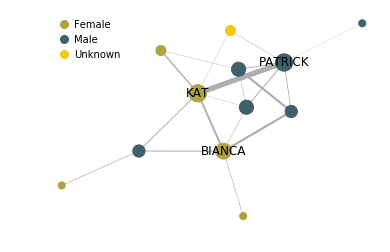

In [69]:
nx.draw_networkx_nodes(g, layout, nodelist = female, node_color = '#ADA342', node_size = female_sizes)
nx.draw_networkx_nodes(g, layout, nodelist = male, node_color = '#40616c', node_size = male_sizes)
nx.draw_networkx_nodes(g, layout, nodelist = unknown, node_color = '#f6ca0e', node_size = unknown_sizes)

nx.draw_networkx_edges(g, layout, width=counts, edge_color="#AEAEAE")

plt.axis('off')

node_labels = fm
nx.draw_networkx_labels(g, layout, labels=node_labels)

legend_elements = [Line2D([0], [0], color = '#ADA342', marker = 'o', label = 'Female', markersize = 8, linestyle = 'None'),
                   Line2D([0], [0], color = '#40616c', marker = 'o', label = 'Male', markersize = 8, linestyle = 'None'),
                   Line2D([0], [0], color = '#f6ca0e', marker = 'o', label = 'Unknown', markersize = 8, linestyle = 'None')]

plt.legend(handles = legend_elements, loc = 'best', frameon = False, handletextpad = 0)